# Growth of decision-consistent and stimulus-specific biases

In [1]:
import sys
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon
from statsmodels.stats.weightstats import DescrStatsW

sys.path.append('..')
from src import utils
utils.setup_matplotlib()

In [2]:
utils.download_dataset("data/processed/behavior")
utils.download_dataset("data/outputs/behavior")

with open("../data/outputs/behavior/results_stimulus_specific_bias_weight.pickle", 'rb') as f:
    ssb_weight = pickle.load(f)
with open("../data/outputs/behavior/bootstrap_stimulus_specific_bias.pickle", 'rb') as f:
    ssb_boot = pickle.load(f)

behavior = pd.read_csv("../data/processed/behavior/behavior.csv")
behavior = behavior[(~np.isnan(behavior['choice'])) & (~np.isnan(behavior['error']))]

downloading data/processed/behavior...
data/processed/behavior already exists. Skipping download...
downloading data/outputs/behavior...
data/outputs/behavior already exists. Skipping download...


---

## Decision-consistent bias

In [3]:
%%capture
id_list  = np.unique(behavior.ID)
dcb_list = np.nan*np.empty((2,5,2,len(id_list)))
for i_id, v_id in enumerate(id_list): 
    for i_t, v_t in enumerate([1,2]):
        for i_r, v_r in enumerate([-21,-4,0,4,21]): 
            idx = (behavior.Timing==v_t) & (behavior.ID==v_id) & (behavior.ref== -v_r)
            dcb_list[i_t,i_r,0,i_id] = utils.circmean(behavior.error[idx&(behavior.choice==2)])
            dcb_list[i_t,i_r,1,i_id] = utils.circmean(behavior.error[idx&(behavior.choice==1)])

dcb_list[:,0,1] = np.nan # omit the 'lapse' (Far incorrect) conditions for visualization
dcb_list[:,4,0] = np.nan # omit the 'lapse' (Far incorrect) conditions for visualization
m_dcb_list = np.nanmedian(dcb_list,axis=-1)
s_dcb_list = np.nanstd(dcb_list,axis=-1)/np.sqrt(50) * 1.96

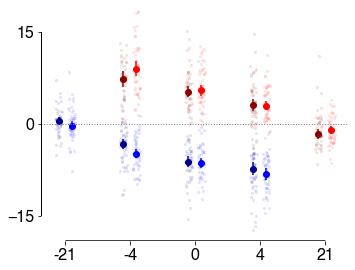

In [4]:
plt.figure()
ax = plt.gca()
utils.set_size([4,3])

devi = 0.1
plt.axhline(y=0,  linestyle='dotted', color='gray', linewidth=1.)

# Early
plt.scatter(np.array([-2,-1,0,1,2])-devi, (m_dcb_list)[0,:,1], color='darkred')
plt.vlines( np.array([-2,-1,0,1,2])-devi, (m_dcb_list-s_dcb_list)[0,:,1], (m_dcb_list+s_dcb_list)[0,:,1], color='darkred')

for i_r, v_r in enumerate([-2,-1,0,1,2]):    
    plt.scatter( np.array([v_r]*50)-devi+ np.random.uniform(-devi/2,devi/2,size=50), 
                dcb_list[0,i_r,1,:], color='darkred', alpha=0.11, linewidth=0, s=10, zorder=0)

plt.scatter(np.array([-2,-1,0,1,2])-devi, (m_dcb_list)[0,:,0], color='darkblue')
plt.vlines( np.array([-2,-1,0,1,2])-devi, (m_dcb_list-s_dcb_list)[0,:,0], (m_dcb_list+s_dcb_list)[0,:,0], color='darkblue')
for i_r, v_r in enumerate([-2,-1,0,1,2]):    
    plt.scatter( np.array([v_r]*50)-devi+ np.random.uniform(-devi/2,devi/2,size=50), 
                dcb_list[0,i_r,0,:], color='darkblue', alpha=0.11, linewidth=0, s=10, zorder=0)

# Late
plt.scatter(np.array([-2,-1,0,1,2])+devi, (m_dcb_list)[1,:,1], color='red')
plt.vlines( np.array([-2,-1,0,1,2])+devi, (m_dcb_list-s_dcb_list)[1,:,1], (m_dcb_list+s_dcb_list)[1,:,1], color='red')
for i_r, v_r in enumerate([-2,-1,0,1,2]):    
    plt.scatter( np.array([v_r]*50)+devi+ np.random.uniform(-devi/2,devi/2,size=50), 
                dcb_list[1,i_r,1,:], color='red', alpha=0.11, linewidth=0, s=10, zorder=0)

plt.scatter(np.array([-2,-1,0,1,2])+devi, (m_dcb_list)[1,:,0], color='blue')
plt.vlines( np.array([-2,-1,0,1,2])+devi, (m_dcb_list-s_dcb_list)[1,:,0], (m_dcb_list+s_dcb_list)[1,:,0], color='blue')
for i_r, v_r in enumerate([-2,-1,0,1,2]):    
    plt.scatter( np.array([v_r]*50)+devi+ np.random.uniform(-devi/2,devi/2,size=50), 
                dcb_list[1,i_r,0,:], color='blue', alpha=0.11, linewidth=0, s=10, zorder=0)
plt.ylim([-19,19])
    
if utils.LABEL:
    plt.xlabel(r"Stimulus - Reference $(\!\!^\circ\!\!)$")    
    plt.ylabel(r"Estimation error $(\!\!^\circ\!\!)$")    

plt.xticks([-2,-1,0,1,2],[-21,-4,0,4,21])
utils.draw_publish_axis(ax, xrange=(-2,2), yrange=(-15,15), xticks=None, yticks=[-15,0,15])
plt.savefig(f'{utils.DIR_FIGURE}/fig4a.pdf',bbox_inches='tight')
plt.show()

In [5]:
dces_e = np.nan * np.zeros([len(id_list),2]) # EL
dces   = np.nan * np.zeros([len(id_list),2,2]) # EL, C/CW

for i_id, v_id in enumerate(id_list):
    sub_df = behavior[behavior.ID == v_id]
    _evi   = -sub_df.ref.to_numpy()
    _dm    = 2.-sub_df.choice.to_numpy()
    _stim  = sub_df.stim.to_numpy()
    _time  = sub_df.Timing.to_numpy()
    _err   = sub_df.error.to_numpy()
    
    for i_t, v_t in enumerate([1,2]):
        idx = (_time==v_t) & (np.abs(_evi)<5)
        dces_e[i_id,i_t] = utils.circmean(_err[idx] * (2*_dm[idx]-1))
        dces[i_id,i_t,0] = utils.circmean(_err[idx&(_dm==1)])
        dces[i_id,i_t,1] = utils.circmean(_err[idx&(_dm==0)])

In [6]:
v_Ecw  = dces[:,0,0]
v_Eccw = dces[:,0,1]
v_Lcw  = dces[:,1,0]
v_Lccw = dces[:,1,1]

ms_cw  = [np.mean(v_Ecw), np.mean(v_Lcw)]
ss_cw  = [np.std(v_Ecw)/np.sqrt(50), np.std(v_Lcw)/np.sqrt(50)]
ms_ccw = [np.mean(v_Eccw), np.mean(v_Lccw)]
ss_ccw = [np.std(v_Eccw)/np.sqrt(50), np.std(v_Lccw)/np.sqrt(50)]


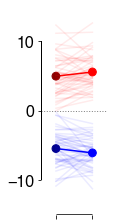

In [7]:
plt.figure()
ax = plt.gca()
utils.set_size([1.4,2.5])

plt.plot([-1,1.5], [ms_cw[0], ms_cw[-1]],   color='red', zorder=0)
plt.plot([-1,1.5], [ms_ccw[0], ms_ccw[-1]], color='blue', zorder=0)

plt.axhline(y=0,  linestyle='dotted', color='gray', linewidth=1.)

plt.errorbar(x=[-1], y=ms_cw[0], yerr=ss_cw[0], fmt="none", color="darkred")
plt.errorbar(x=[1.5], y=ms_cw[-1], yerr=ss_cw[-1], fmt="none", color="red")
plt.scatter(x=[-1,1.5], y=ms_cw, color=["darkred", "red"], s=60)
for i in range(50):
    plt.plot([-1,1.5], [v_Ecw[i],v_Lcw[i]], color='red', alpha=0.08)

plt.scatter(x=[-1,1.5], y=ms_ccw, color=["darkblue", "blue"], s=60)
plt.errorbar(x=[-1], y=ms_ccw[0], yerr=ss_ccw[0], fmt="none", color="darkblue")
plt.errorbar(x=[1.5], y=ms_ccw[-1], yerr=ss_ccw[-1], fmt="none", color="blue")
for i in range(50):
    plt.plot([-1,1.5], [v_Eccw[i],v_Lccw[i]], color='blue', alpha=0.08)  

plt.xlim([-2,2.5])
plt.ylim([-15,15])
    
if utils.LABEL:
    plt.ylabel(r"Estimation error $(\!\!^\circ\!\!)$")    
    plt.xticks([-1,1.5], ['Early', 'Late'])

else:
    plt.xticks([-1,1.5], ['', ''])

utils.draw_publish_axis(ax, xrange=(-1,1.5), yrange=(-10,10), xticks=None, yticks=[-10,0,10])
plt.savefig(f'{utils.DIR_FIGURE}/fig4b.pdf', bbox_inches='tight')
plt.show()

In [8]:
ttest  = DescrStatsW(dces_e[:,1]-dces_e[:,0])
wilcox = wilcoxon(dces_e[:,1]-dces_e[:,0])
print("Decision-consistent bias: Early vs. Late")
print('\nPaired samples t-test')
print('t(49)=',  ttest.ttest_mean()[0], 'p=', ttest.ttest_mean()[1])
print('95% CI=', ttest.tconfint_mean())
print('\nWilcoxon signed-rank test (without continuity correction)')
print('V=', wilcox[0], 'p=', wilcox[1])

Decision-consistent bias: Early vs. Late

Paired samples t-test
t(49)= 2.9290381940376546 p= 0.005148292958772938
95% CI= (0.20351036171494996, 1.0930935224442342)

Wilcoxon signed-rank test (without continuity correction)
V= 320.0 p= 0.002177311550955709


---

## Stimulus-specific bias

In [9]:
stims = np.linspace(0,180,num=24,endpoint=False)
mE = -np.mean(ssb_boot[:,0],axis=-1)
sE = np.std(ssb_boot[:,0],axis=-1)
mL = -np.mean(ssb_boot[:,1],axis=-1)
sL = np.std(ssb_boot[:,1],axis=-1)

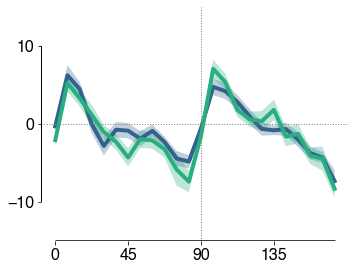

In [10]:
plt.figure()
ax = plt.gca()
utils.set_size([4,3])

plt.plot(stims, mE, color='#33638D',linewidth=4.)
plt.plot(stims, mL, color='#29AF7F',linewidth=4.)

plt.axvline(x=90, linestyle='dotted', color='gray', linewidth=1.)
plt.axhline(y=0,  linestyle='dotted', color='gray', linewidth=1.)
plt.fill_between(x=stims, y1=mE-sE, y2=mE+sE, color='#33638D', alpha=0.3, edgecolor="none", linewidth=0)
plt.fill_between(x=stims, y1=mL-sL, y2=mL+sL, color='#29AF7F', alpha=0.3, edgecolor="none", linewidth=0)

plt.ylim([-15,15])

if utils.LABEL:
    plt.xlabel(r"Stimulus $(\!\!^\circ\!\!)$")    
    plt.ylabel(r"Bias at $t_\mathrm{DM}$ $(\!\!^\circ\!\!)$")

utils.draw_publish_axis(ax, xrange=(0,172.5), yrange=(-10,10), xticks=[0,45,90,135], yticks=[-10,0,10])
plt.savefig(f'{utils.DIR_FIGURE}/fig4c.pdf')
plt.show()

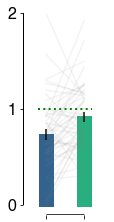

In [11]:
v_E = ssb_weight[:,0]
v_L = ssb_weight[:,1]

ms = [np.mean(v_E), np.mean(v_L)]
ss = [np.std(v_E)/np.sqrt(50), np.std(v_L)/np.sqrt(50)]

plt.figure()
ax = plt.gca()
utils.set_size([1.4,2.5])

for i in range(50):
    plt.plot([-1,1.5], [v_E[i],v_L[i]], color='gray', alpha=0.09)
    
bar = plt.bar(x=[-1,1.5], height=ms, color=["#33638D", "#29AF7F"])
bar[0].set_edgecolor('#33638D')
bar[1].set_edgecolor('#29AF7F')
bar[0].set_linewidth(3)
bar[1].set_linewidth(3)
plt.errorbar(x=[-1,1.5], y=ms, yerr=ss, fmt="none", color="k")

plt.xlim([-2.5,3])
plt.ylim([-0.1,2])

ax.hlines(y=1, xmin=-1.5, xmax=2, linestyle='dotted', color='green', linewidth=2.)

if utils.LABEL:
    plt.ylabel(r"Bias weight", labelpad=10)
    plt.xticks([-1,1.5], ['Early', 'Late'])
else:
    plt.xticks([-1,1.5], ['', ''])
utils.draw_publish_axis(ax, xrange=(-1,1.5), yrange=(0,2), xticks=None, yticks=[0,1,2])
plt.savefig(f'{utils.DIR_FIGURE}/fig4d.pdf')
plt.show()

In [12]:
ttest  = DescrStatsW(v_L-v_E)
wilcox = wilcoxon(v_L-v_E)
print("Bias weight: Early vs. Late")
print('\nPaired samples t-test')
print('t(49)=',  ttest.ttest_mean()[0], 'p=', ttest.ttest_mean()[1])
print('95% CI=', ttest.tconfint_mean())
print('\nWilcoxon signed-rank test (without continuity correction)')
print('V=', wilcox[0], 'p=', wilcox[1])

Bias weight: Early vs. Late

Paired samples t-test
t(49)= 3.2439943624220255 p= 0.002125588822461477
95% CI= (0.06968141602816286, 0.2965574337205209)

Wilcoxon signed-rank test (without continuity correction)
V= 320.0 p= 0.002177311550955709
